# Forecasting with Uber Orbit with MLflow

Run the setup script first to get our train val dataset

In [2]:
from setup import start_spark, extract_data

spark = start_spark(sesh_name = 'Jupyter Orbit Modelling')
train, val = extract_data(spark)
spark.stop()

In [4]:
train.head()

,total_rides,total_takings
pickup_date,,
2013-08-01,307272,4.567414e+06
2013-08-02,236761,3.534616e+06
2013-08-03,226554,3.182267e+06
2013-08-04,202310,3.073609e+06
2013-08-05,406487,6.657713e+06


In [23]:
# orbit doesn't work with datetime index
train['pickup_date'] = train.index

## MLflow Setup

In [24]:
import mlflow

In [25]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/


The taxi_daily_forecast experiment has already been created

In [26]:
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.models.dlt import DLTFull
import numpy as np

In [27]:
import orbit
orbit.__version__

'1.0.13'

In [28]:
# need to createa pyfunc for mlflow

class OrbitDLTModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    #def load_context(self, context)
    #    from
    def predict(self, model_input):
        return self.model.predict(df=model_input) 

In [29]:
# backtesting parameters
min_train_len = 12*4*7
forecast_len = 28
incremental_len = 14
window_type='rolling'

In [35]:
ex_splitter = TimeSeriesSplitter(df=train,
                                 min_train_len=min_train_len,
                                 incremental_len=incremental_len,
                                 forecast_len=forecast_len, 
                                 window_type=window_type,
                                 date_col='pickup_date')

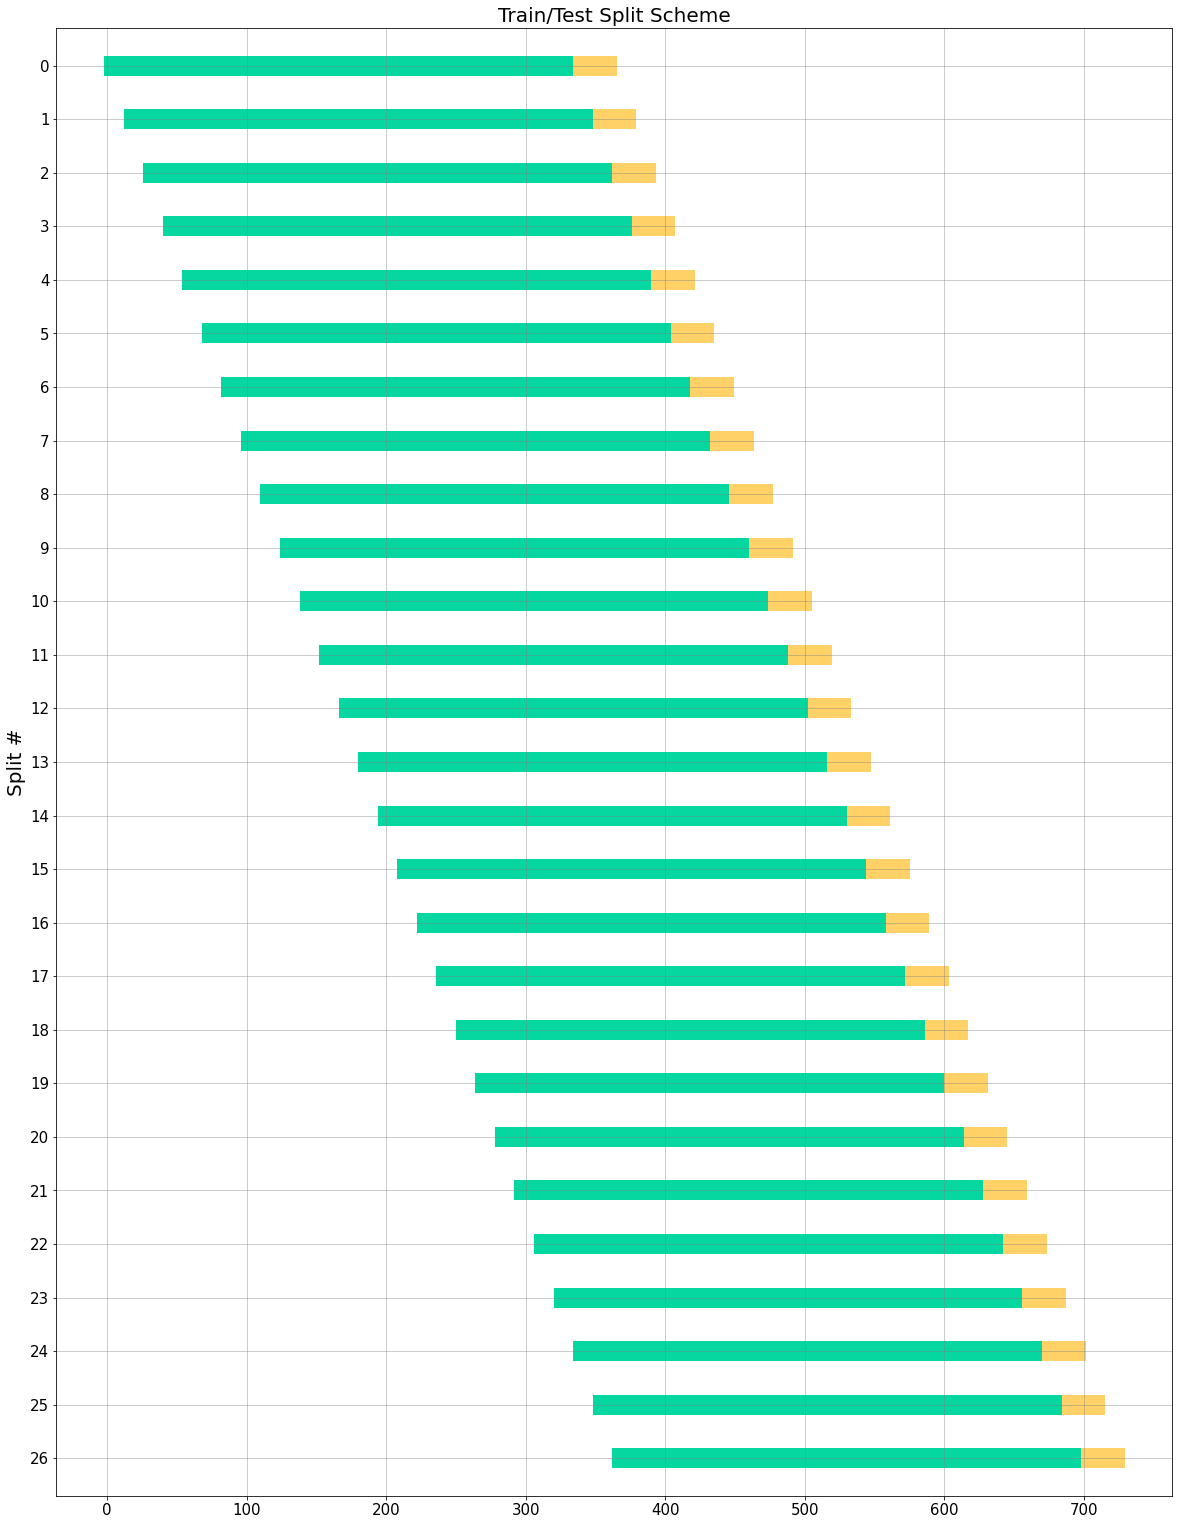

In [36]:
_ = ex_splitter.plot()

In [39]:
# orbit requires that the date_col is datetime
orbit_train = train[['pickup_date', 'total_rides']].copy()
#orbit_train['pickup_date'] = pd.to_datetime(orbit_train['pickup_date'])

## Develop the training Loop

In [40]:
dlt = DLTFull(
        response_col='total_rides', 
        date_col='pickup_date',
        seasonality=7,
    )
    
bt = BackTester(
        model=dlt,
        df=orbit_train,
        min_train_len=min_train_len,
        incremental_len=incremental_len,
        forecast_len=forecast_len,
        window_type=window_type,
    )


In [41]:
bt.fit_predict()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

In [43]:
predicted_df = bt.get_predicted_df()
predicted_df.head()

,date,split_key,training_data,actuals,prediction
0,2013-08-01,0,True,307272,308208.305982
1,2013-08-02,0,True,236761,313902.014584
2,2013-08-03,0,True,226554,275765.452620
3,2013-08-04,0,True,202310,262499.644841
4,2013-08-05,0,True,406487,230725.695971


In [44]:
bt.score()

,metric_name,metric_values,is_training_metric
0,smape,7.960855e-02,False
1,wmape,7.576821e-02,False
2,mape,8.514606e-02,False
3,mse,3.295074e+09,False
4,mae,3.615376e+04,False
5,rmsse,1.194705e+00,False


In [45]:
bt.score()[bt.score()['metric_name']=='mae'].metric_values.values[0]

36153.75739147489

## Training with Logging to MLflow

In [46]:
orbit_conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'orbit-ml=={0}'.format(orbit.__version__)
        ]
    }],
    "name": "orbitenv"
}

In [47]:
#WIP
with mlflow.start_run(experiment_id=15):
    dlt = DLTFull(
        response_col='total_rides', 
        date_col='pickup_date',
        seasonality=7,
    )
    
    bt = BackTester(
        model=dlt,
        df=orbit_train,
        min_train_len=min_train_len,
        incremental_len=incremental_len,
        forecast_len=forecast_len,
        window_type=window_type,
    )
    
    bt.fit_predict()
    
    mlflow.log_metric("rmse", np.sqrt(bt.score()[bt.score()['metric_name']=='mse'].metric_values.values[0]))
    mlflow.log_metric("mae", bt.score()[bt.score()['metric_name']=='mae'].metric_values.values[0])
    mlflow.log_metric("mape", bt.score()[bt.score()['metric_name']=='mape'].metric_values.values[0])
    
    #mlflow.pyfunc.log_model("model", conda_env=orbit_conda_env, python_model=ProphetModel(m))
    #print(
    #        "Logged model with URI: runs:/{run_id}/model".format(
    #            run_id=mlflow.active_run().info.run_id
    #        )
    #    )   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

## Fit final Model

In [55]:
dlt.fit(df=orbit_train)

val['pickup_date'] = val.index
orbit_val = val[['pickup_date', 'total_rides']]
predicted_df = dlt.predict(df=orbit_val)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Post Fit Diagnostics

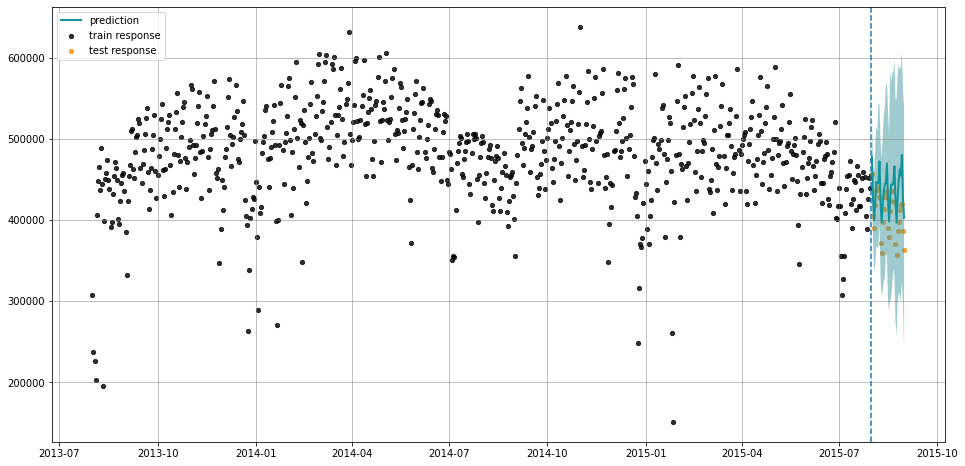

<AxesSubplot:>

In [57]:
from orbit.diagnostics.plot import plot_predicted_data

plot_predicted_data(
    training_actual_df=orbit_train, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=orbit_val
)